# Sprint 13 - Projeto Final

### Tarefa

Segmente usuários com base em seus perfis de consumidor.

- Realize a análise exploratória de dados.
- Segmente os usuários com base no histórico de compras. Sinta-se à vontade para implementar suas próprias ideias para segmentar usuários. Pense em como a segmentação pode ajudar você a desenvolver ofertas mais personalizadas para diferentes usuários. Tente formar segmentos com base no que os usuários compram. Você pode analisar suas compras e segmentar as mercadorias de acordo com a categoria de produto a que pertencem.
- Formule e teste hipóteses estatísticas.

### **Descrição dos dados**

O conjunto de dados contém o histórico de transações da Everything Plus, uma loja online que vende utensílios domésticos.

O arquivo `ecommerce_dataset_us.csv` contém as seguintes colunas:

`InvoiceNo` — identificador de pedido

`StockCode` — identificador de item

`Description` — nome de item

`Quantity`

`InvoiceDate` — data do pedido

`UnitPrice` — preço por item

`CustomerID`

Faça uma lista de 5 a 10 fontes (documentação, artigos) que você usou enquanto trabalhava no projeto. Forneça breves explicações sobre as perguntas que cada fonte o ajudou a responder. Prepare uma apresentação com suas conclusões. Você pode usar qualquer ferramenta que desejar para fazer a apresentação, mas deve enviá-la em PDF. Coloque o link no corpo do projeto principal.

### Dashboards

1. Sugestão 1
    1. Faça um diagrama para o número de compras por dia
    2. Adicione um indicador para o número de clientes
    3. Adicione um filtro de data de compra
2. Sugestão 2
    1. Faça um diagrama para o total de compras por dia
    2. Trace um histograma de totais de compras individuais
    3. Adicione um filtro de data de compra

In [89]:
# Importando as bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

##bibliotecas para aprendizado de maquina
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn import base

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

# Bibliotecas para codificação de dados
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import FeatureHasher

## 1 Tratamento dos dados

- Atributos para arrumar
    - Alterar o nome das colunas para snake-case e tudo em letras minusculas
    - Remover valores nulos em customer_id da tabela já que não me permitem criar um perfil de cliente;
    - Procurar e remover valores duplicados;
    - Alterar o tipo de dados de invoice_date para datetime;
    - Remover da tabela valores que estão negativos na coluna 'quantity';
    - Conferir e tratar os dados da coluna 'unit_price' se necessário;
    - Adicionar uma coluna com total gasto por usuário (total_spent)

In [2]:
ecommerce = pd.read_csv('dataset/ecommerce_dataset_us.csv')

In [3]:
ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    65535 non-null  object 
 1   StockCode    65535 non-null  object 
 2   Description  65372 non-null  object 
 3   Quantity     65535 non-null  int64  
 4   InvoiceDate  65535 non-null  object 
 5   UnitPrice    65535 non-null  float64
 6   CustomerID   41231 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 3.5+ MB


In [4]:
# Renomear as colunas para que correspondam a Snake-Case e que tudo fique em letra minuscula
new_column_names = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id']

ecommerce.rename(columns=dict(zip(ecommerce.columns, new_column_names)), inplace=True)

In [5]:
print(ecommerce.head())

  invoice_no stock_code                     description  quantity  \
0    C541433      23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   
1     541431      23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   
4     537626      22726      ALARM CLOCK BAKELIKE GREEN         4   

       invoice_date  unit_price  customer_id  
0  01/16/2019 10:17        1.04      12346.0  
1  01/16/2019 10:01        1.04      12346.0  
2  12/05/2018 14:57        4.95      12347.0  
3  12/05/2018 14:57        3.75      12347.0  
4  12/05/2018 14:57        3.75      12347.0  


In [6]:
# Tratar os dados da coluna customer_id
ecommerce_clean = ecommerce[~ecommerce['customer_id'].isna()]

In [7]:
ecommerce_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41231 entries, 0 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    41231 non-null  object 
 1   stock_code    41231 non-null  object 
 2   description   41231 non-null  object 
 3   quantity      41231 non-null  int64  
 4   invoice_date  41231 non-null  object 
 5   unit_price    41231 non-null  float64
 6   customer_id   41231 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.5+ MB


In [8]:
# Atualizar o formato de dados de 'customer_id' para int
ecommerce_clean['customer_id'] = ecommerce_clean['customer_id'].astype('int')

C:\Users\renan\AppData\Local\Temp\ipykernel_4700\3316102296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean['customer_id'] = ecommerce_clean['customer_id'].astype('int')


### 1.1 Remover possiveis espaços duplos da coluna 'description'

In [9]:
# Removendo os espaços duplos

ecommerce_clean['description'] = ecommerce_clean['description'].str.replace(r'\s+', ' ', regex=True)

C:\Users\renan\AppData\Local\Temp\ipykernel_4700\1543203026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean['description'] = ecommerce_clean['description'].str.replace(r'\s+', ' ', regex=True)


### 1.2 Remover dados duplicados

In [10]:
# Obter o total de valores duplicados
print(ecommerce_clean.duplicated().value_counts())

False    40579
True       652
Name: count, dtype: int64


In [11]:
# Removendo duplicados
ecommerce_clean = ecommerce_clean.drop_duplicates()

In [12]:
# Conferindo se removeu os duplicados
print(ecommerce_clean.duplicated().value_counts())

False    40579
Name: count, dtype: int64


- A remoção dos dados duplicados funcionou.

### 1.3 Tratando os dados da coluna 'quantity'

In [13]:
# Filtrando os dados para remover valores negativos de 'quantity' selecionando apenas valores maiores ou iguais a 1

ecommerce_clean = ecommerce_clean[ecommerce_clean['quantity']>= 1]

In [14]:
ecommerce_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39531 entries, 1 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   invoice_no    39531 non-null  object 
 1   stock_code    39531 non-null  object 
 2   description   39531 non-null  object 
 3   quantity      39531 non-null  int64  
 4   invoice_date  39531 non-null  object 
 5   unit_price    39531 non-null  float64
 6   customer_id   39531 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 2.3+ MB


In [15]:
# Alterar o tipo de dados de 'invoice_date' para datetime

ecommerce_clean['invoice_date'] = pd.to_datetime(ecommerce_clean['invoice_date'])

In [16]:
print(ecommerce_clean.head(3))

  invoice_no stock_code                     description  quantity  \
1     541431      23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   

         invoice_date  unit_price  customer_id  
1 2019-01-16 10:01:00        1.04        12346  
2 2018-12-05 14:57:00        4.95        12347  
3 2018-12-05 14:57:00        3.75        12347  


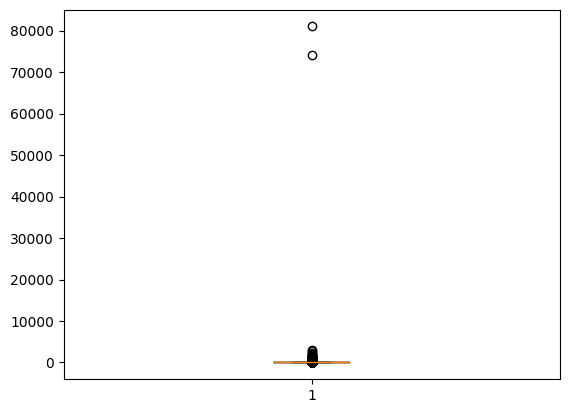

In [17]:
# Conferir os dados de quantidade pois parece ter alguns valores extremos

quantity_values = ecommerce_clean['quantity']

plt.boxplot(quantity_values)
plt.show()

In [18]:
# Filtrar os dados para remover dados de 'quantity' acima de 10000

ecommerce_clean = ecommerce_clean[ecommerce_clean['quantity']<=10000]

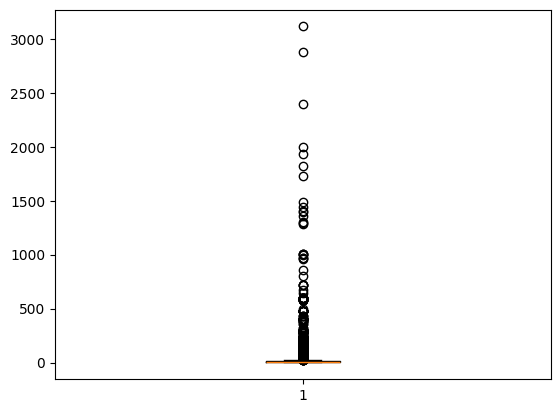

In [19]:
# Conferir os dados de quantidade após remoção

quantity_values_2 = ecommerce_clean['quantity']

plt.boxplot(quantity_values_2)
plt.show()

In [20]:
''' Acredito que tenha algo de errado com esses dados com valores acima de 1000 itens do mesmo pedido
    Estou pensando em agrupar por usuário e pedido e ver o máximo de produtos pedidos'''

group_user_orders = ecommerce_clean.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_user_orders.head(20))

customer_id  description                         unit_price
15749        FAIRY CAKE FLANNEL ASSORTED COLOUR  2.10          3114
16754        WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.18          2880
16029        GROW A FLYTRAP OR SUNFLOWER IN TIN  0.94          2400
15749        GIN + TONIC DIET METAL SIGN         1.85          2000
             WHITE HANGING HEART T-LIGHT HOLDER  2.55          1930
15299        ASSORTED COLOUR T-LIGHT HOLDER      0.55          1824
12875        ASSORTED LAQUERED INCENSE HOLDERS   0.17          1728
12755        ROUND SNACK BOXES SET OF 4 FRUITS   2.55          1488
14156        ASSORTED INCENSE PACK               0.16          1440
16754        RED HARMONICA IN BOX                1.06          1400
17857        MINI PAINT SET VINTAGE              0.55          1394
17450        HEART OF WICKER SMALL               1.93          1356
15749        TEA TIME TEA TOWELS                 2.55          1300
17306        PACK OF 12 LONDON TISSUES           0.25   

- Com essa informação vejo que alguns dados os pedidos provavelmente estão errados, sendo assim vou filtrar o dataframe para quantidade superior e inferior a 300 pedidos e ver o resultado nos dados

In [21]:
# Filtrando as quantidades com limite de 300

above_300 = ecommerce_clean[ecommerce_clean['quantity'] >= 300]
below_300 = ecommerce_clean[ecommerce_clean['quantity'] < 300]

In [22]:
above_300.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 479 to 40054
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    89 non-null     object        
 1   stock_code    89 non-null     object        
 2   description   89 non-null     object        
 3   quantity      89 non-null     int64         
 4   invoice_date  89 non-null     datetime64[ns]
 5   unit_price    89 non-null     float64       
 6   customer_id   89 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 5.2+ KB


In [23]:
below_300.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39440 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    39440 non-null  object        
 1   stock_code    39440 non-null  object        
 2   description   39440 non-null  object        
 3   quantity      39440 non-null  int64         
 4   invoice_date  39440 non-null  datetime64[ns]
 5   unit_price    39440 non-null  float64       
 6   customer_id   39440 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.3+ MB


In [24]:
# Conferir a lista com os valores máximos até 300 pedidos

group_below_300 = below_300.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_below_300.head(20))

customer_id  description                         unit_price
15311        DECORATIVE CATS BATHROOM BOTTLE     0.42          288
17511        DISCO BALL CHRISTMAS DECORATION     0.10          288
18092        MOROCCAN TEA GLASS                  0.65          288
14646        5 HOOK HANGER RED MAGIC TOADSTOOL   1.45          288
17404        TEA BAG PLATE RED RETROSPOT         0.85          288
16422        SET/10 RED POLKADOT PARTY CANDLES   1.06          288
14156        SET/5 RED SPOTTY LID GLASS BOWLS    2.55          288
17511        FELT FARM ANIMAL WHITE BUNNY        0.19          288
14646        ASSORTED EASTER DECORATIONS BELLS   1.06          288
             PLASTERS IN TIN WOODLAND ANIMALS    1.45          288
16191        HAND WARMER BABUSHKA DESIGN         0.85          288
16210        POTTERING MUG                       0.42          288
16684        FANCY FONT BIRTHDAY CARD            0.36          288
14646        SET/10 BLUE POLKADOT PARTY CANDLES  1.06          288
16

- Olhando os produtos posso dizer que mesmo filtrando os pedidos com quantidade inferior a 300, ainda temos produtos com valores que não aparentam ser adequados para esses tipos de produtos.
- É necessário realizar novo tratamento desses dados e aplicar outra filtragem, nesse caso trabalharei com 100 itens

In [25]:
# Filtrando as quantidades com limite de 100

above_100 = ecommerce_clean[ecommerce_clean['quantity'] >= 100]
below_100 = ecommerce_clean[ecommerce_clean['quantity'] < 100]

In [26]:
above_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 621 entries, 45 to 40644
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    621 non-null    object        
 1   stock_code    621 non-null    object        
 2   description   621 non-null    object        
 3   quantity      621 non-null    int64         
 4   invoice_date  621 non-null    datetime64[ns]
 5   unit_price    621 non-null    float64       
 6   customer_id   621 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 36.4+ KB


In [27]:
below_100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38908 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    38908 non-null  object        
 1   stock_code    38908 non-null  object        
 2   description   38908 non-null  object        
 3   quantity      38908 non-null  int64         
 4   invoice_date  38908 non-null  datetime64[ns]
 5   unit_price    38908 non-null  float64       
 6   customer_id   38908 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.2+ MB


In [28]:
# Conferir a lista com os valores máximos até 100 pedidos

group_below_100 = below_100.groupby(['customer_id','description','unit_price'])['quantity'].max().sort_values(ascending=False)
print(group_below_100.head(20))

customer_id  description                          unit_price
12415        PINK POLKADOT PLATE                  1.45          96
12370        HEART DECORATION PAINTED ZINC        0.65          96
14646        PLASTERS IN TIN VINTAGE PAISLEY      1.45          96
13089        HEART IVORY TRELLIS SMALL            1.25          96
14646        PLASTERS IN TIN STRONGMAN            1.45          96
14258        SET/6 RED SPOTTY PAPER PLATES        0.64          96
14646        BLUE POLKADOT CUP                    0.72          96
14258        SET/20 RED RETROSPOT PAPER NAPKINS   0.64          96
15061        MAGIC DRAWING SLATE SPACEBOY         0.36          96
17511        6 RIBBONS SHIMMERING PINKS           0.42          96
14062        HAND WARMER BABUSHKA DESIGN          0.85          96
17511        BAG 125g SWIRLY MARBLES              0.36          96
15330        FEATHER PEN LIGHT PINK               0.39          96
14646        BLUE STRIPE CERAMIC DRAWER KNOB      1.06          96
1

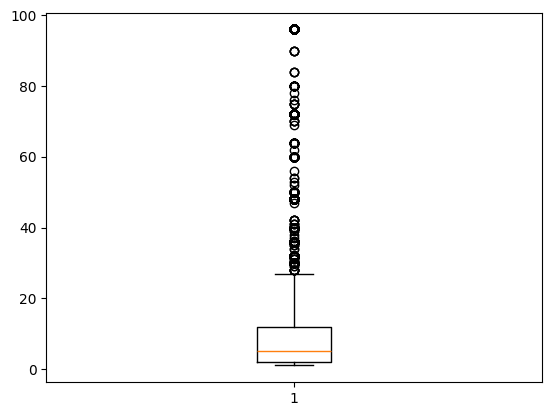

In [29]:
# Plotar histograma de quantidade inferior a 100

quant_below_100 = below_100['quantity']

plt.boxplot(quant_below_100)
plt.show()

- Com base neste novo boxplot é possível ver a distribuição dos dados onde temos o limite superior próximo a 20.
    - O passo agora é calcular esse limite, realizar nova filtragem dos dados e observar se vale a pena manter a nova filtragem ou utilizar os dados com quantidade abaixo de 100

In [30]:
''' Observação para mim mesmo, eu poderia ter realizado isso logo após confeccionar o primeiro boxplot ao invés de ficar adivinhando valores'''

# Calcular o limite superior do boxplot

# Calcular o terceiro quartil
q3 = below_100['quantity'].quantile(0.75)

# Calcular o primeiro quartil
q1 = below_100['quantity'].quantile(0.25)

# Calcular o intervalo interquartil (IQR)
iqr = q3-q1

# Calcular o limite superior
upper_limit = q3 + 1.5 * iqr

print("O limite superior é: ", upper_limit)

O limite superior é:  27.0


- Como descobri que o limite superior é de 27, vou realizar a filtragem dos dados para 'quantity' até 27 e depois estudar os dados

In [31]:
# Filtrando os dados para quantity até 27
below_27 = ecommerce_clean[ecommerce_clean['quantity'] <= 27]

In [32]:
below_27.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36844 entries, 2 to 41230
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    36844 non-null  object        
 1   stock_code    36844 non-null  object        
 2   description   36844 non-null  object        
 3   quantity      36844 non-null  int64         
 4   invoice_date  36844 non-null  datetime64[ns]
 5   unit_price    36844 non-null  float64       
 6   customer_id   36844 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(3)
memory usage: 2.1+ MB


In [33]:
# Conferindo o total de usuários únicos após a filtragem

unique_users_27 = below_27['customer_id'].nunique()

print(unique_users_27)

1680


- Com base nos resultados obtidos temos 1680 usuários únicos no novo dataframe filtrado

### 1.4 Estudando a coluna 'unit_price'

- Antes de mais nada, vou criar renomear o dataframe 'below_27' para 'ecommerce_clean_27' assim entendo de onde vieram esses dados já que eles foram limpos uma vez e filtrados.

In [34]:
# Renomeando o Dataframe para trabalho

ecommerce_clean_27 = below_27

In [35]:
# Conferir a lista com os valores máximos até 100 pedidos

group_unit_price = ecommerce_clean_27.groupby(['description','quantity'])['unit_price'].max().sort_values(ascending=False)
print(group_unit_price.head(20))

description                        quantity
VINTAGE RED KITCHEN CABINET        1           295.00
LOVE SEAT ANTIQUE WHITE METAL      2           175.00
RUSTIC SEVENTEEN DRAWER SIDEBOARD  1           165.00
REGENCY MIRROR WITH SHUTTERS       1           165.00
CARRIAGE                           1           150.00
RUSTIC SEVENTEEN DRAWER SIDEBOARD  2           145.00
CHEST NATURAL WOOD 20 DRAWERS      1           125.00
VINTAGE RED KITCHEN CABINET        2           125.00
VINTAGE BLUE KITCHEN CABINET       1           125.00
                                   2           125.00
CHEST NATURAL WOOD 20 DRAWERS      4           110.00
VINTAGE POST OFFICE CABINET        1            79.95
SCHOOL DESK AND CHAIR              1            65.00
                                   2            65.00
VINTAGE POST OFFICE CABINET        10           52.77
HALL CABINET WITH 3 DRAWERS        1            49.95
PINK PAINTED KASHMIRI CHAIR        4            42.95
POSTAGE                            2  

- Observando os preços dos itens, os mesmos parecem de acordo com os itens em questão.

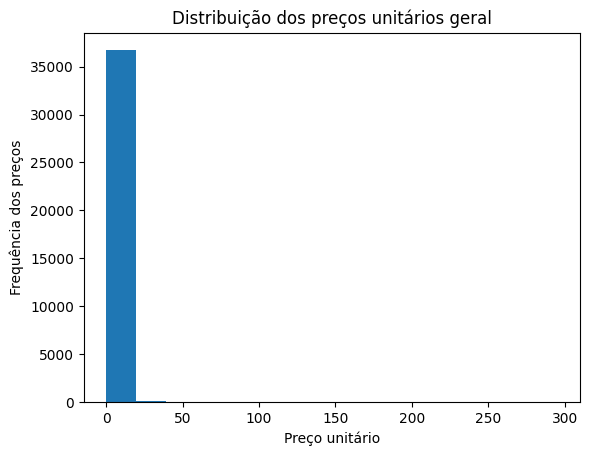

In [36]:
# Histograma da distribuição dos preços
plt.hist(ecommerce_clean_27['unit_price'], bins=15)
plt.ylabel('Frequência dos preços')
plt.xlabel('Preço unitário')
plt.title('Distribuição dos preços unitários geral')
plt.show()

- O histograma nos mostra que a grande maioria dos preços unitários dos produtos se encontra entre zero e 25.

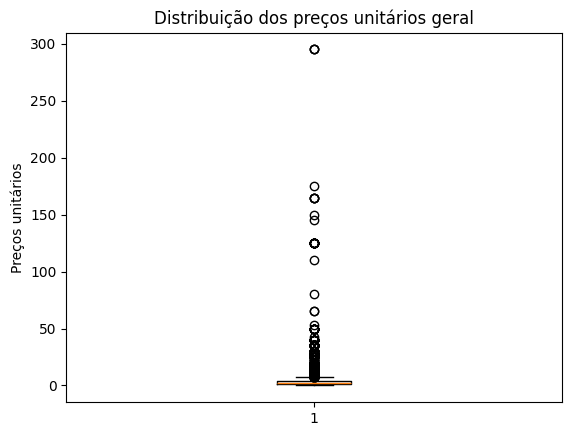

In [37]:
# Boxplot da distribuição dos preços
plt.boxplot(ecommerce_clean_27['unit_price'])
plt.ylabel('Preços unitários')
plt.title('Distribuição dos preços unitários geral')
plt.show()

- Com o boxplot dos preços unitarios podemos ver que há vários produtos com valores outliers justificados pelo tipo de produto em si.

In [38]:
# Calcular o limite superior do boxplot

# Calcular o terceiro quartil
q3 = ecommerce_clean_27['unit_price'].quantile(0.75)

# Calcular o primeiro quartil
q1 = ecommerce_clean_27['unit_price'].quantile(0.25)

# Calcular o intervalo interquartil (IQR)
iqr = q3-q1

# Calcular o limite superior
upper_limit = q3 + 1.5 * iqr

print("O limite superior de preço é: ", upper_limit)

O limite superior de preço é:  7.5


- Pelo boxplot podemos observar que o limite superior de preço unitario é 7,5 e como a loja vende produtos muito mais caros, mas que saem com menos frequência, isso justifica os outliers.

## 2 Adição de dados

### 2.1 Criar uma coluna com o valor total gasto por usuário

In [39]:
ecommerce_clean_27['total_spent'] = (ecommerce_clean_27['unit_price'] * ecommerce_clean_27['quantity'])

C:\Users\renan\AppData\Local\Temp\ipykernel_4700\3784831467.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27['total_spent'] = (ecommerce_clean_27['unit_price'] * ecommerce_clean_27['quantity'])


In [40]:
print(ecommerce_clean_27.head())

  invoice_no stock_code                     description  quantity  \
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   
4     537626      22726      ALARM CLOCK BAKELIKE GREEN         4   
5     537626      22727       ALARM CLOCK BAKELIKE RED          4   
6     537626      22728       ALARM CLOCK BAKELIKE PINK         4   

         invoice_date  unit_price  customer_id  total_spent  
2 2018-12-05 14:57:00        4.95        12347        14.85  
3 2018-12-05 14:57:00        3.75        12347        15.00  
4 2018-12-05 14:57:00        3.75        12347        15.00  
5 2018-12-05 14:57:00        3.75        12347        15.00  
6 2018-12-05 14:57:00        3.75        12347        15.00  


#### 2.1.1 Conferindo se todos os valores são numéricos

In [41]:
#Imprimindo para ver se todos os valores da coluna total_spent são numéricos
try:
    pd.to_numeric(ecommerce_clean_27['total_spent'])
    print("A coluna 'total_spent' contém apenas números.")
except ValueError:
    print("A coluna 'total_spent' contém valores não numéricos.")

A coluna 'total_spent' contém apenas números.


### 2.2 Adicionar coluna de data apenas no dataframe

In [42]:
ecommerce_clean_27['date'] = ecommerce_clean_27['invoice_date'].dt.date

C:\Users\renan\AppData\Local\Temp\ipykernel_4700\1964287090.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27['date'] = ecommerce_clean_27['invoice_date'].dt.date


In [43]:
# Obtendo os resultados pós adição da coluna 'date'
print(ecommerce_clean_27.head())

  invoice_no stock_code                     description  quantity  \
2     537626     85232D   SET/3 DECOUPAGE STACKING TINS         3   
3     537626      22725  ALARM CLOCK BAKELIKE CHOCOLATE         4   
4     537626      22726      ALARM CLOCK BAKELIKE GREEN         4   
5     537626      22727       ALARM CLOCK BAKELIKE RED          4   
6     537626      22728       ALARM CLOCK BAKELIKE PINK         4   

         invoice_date  unit_price  customer_id  total_spent        date  
2 2018-12-05 14:57:00        4.95        12347        14.85  2018-12-05  
3 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  
4 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  
5 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  
6 2018-12-05 14:57:00        3.75        12347        15.00  2018-12-05  


In [44]:
ecommerce_clean_27.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36844 entries, 2 to 41230
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    36844 non-null  object        
 1   stock_code    36844 non-null  object        
 2   description   36844 non-null  object        
 3   quantity      36844 non-null  int64         
 4   invoice_date  36844 non-null  datetime64[ns]
 5   unit_price    36844 non-null  float64       
 6   customer_id   36844 non-null  int32         
 7   total_spent   36844 non-null  float64       
 8   date          36844 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 2.7+ MB


In [45]:
#Criar uma tabela para resumir os dados
pd.DataFrame([{'products': len(ecommerce_clean_27['stock_code'].value_counts()),
               'transactions':len(ecommerce_clean_27['invoice_no'].value_counts()),
               'customers':len(ecommerce_clean_27['customer_id'].value_counts()),
               }], columns=['products','transactions','customers'], index=['quantity'])

,products,transactions,customers
quantity,2543,3438,1680


- Após todo o tratamento dos dados podemos ver que os resultados advém de 1680 usuários, os quais compraram 2543 produtos diferentes sendo que o total de transações realizadas foi de 3438.

## 3 Análise de Coorte

## 4 Codificação dos dados 

### 4.1 Label Encoding

In [46]:
ecommerce_clean_27.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36844 entries, 2 to 41230
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_no    36844 non-null  object        
 1   stock_code    36844 non-null  object        
 2   description   36844 non-null  object        
 3   quantity      36844 non-null  int64         
 4   invoice_date  36844 non-null  datetime64[ns]
 5   unit_price    36844 non-null  float64       
 6   customer_id   36844 non-null  int32         
 7   total_spent   36844 non-null  float64       
 8   date          36844 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 2.7+ MB


In [47]:
''' A coluna 'invoice_date' está dando problema na transformação utilizando label encoding. 
Na hora de realizar a regressão logistica ela não reconhece o formato datetime, ou seja, ou eu transformo para object ou removo ela.
Nesse caso, como tenho a coluna date acredito que vou remover a invoice_date'''

ecommerce_clean_27.drop(['invoice_date'], axis=1, inplace=True)



C:\Users\renan\AppData\Local\Temp\ipykernel_4700\2563632898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_clean_27.drop(['invoice_date'], axis=1, inplace=True)


' Ao tentar realizar'

In [48]:
#dividindo o conjunto de dados

X = ecommerce_clean_27.drop(columns=['description'])
y = ecommerce_clean_27['description']

#Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [49]:
# Renomear o dataframe para fazer a categorização das colunas com tipo objeto
train = ecommerce_clean_27

In [50]:
print(train.head(10).sort_values(by='description'))

   invoice_no stock_code                        description  quantity  \
8      537626      22375  AIRLINE BAG VINTAGE JET SET BROWN         4   
3      537626      22725     ALARM CLOCK BAKELIKE CHOCOLATE         4   
4      537626      22726         ALARM CLOCK BAKELIKE GREEN         4   
7      537626      22729        ALARM CLOCK BAKELIKE ORANGE         4   
6      537626      22728          ALARM CLOCK BAKELIKE PINK         4   
5      537626      22727          ALARM CLOCK BAKELIKE RED          4   
11     537626     84997C  BLUE 3 PIECE POLKADOT CUTLERY SET         6   
10     537626      22212          FOUR HOOK WHITE LOVEBIRDS         6   
9      537626      22497    SET OF 2 TINS VINTAGE BATHROOM          4   
2      537626     85232D      SET/3 DECOUPAGE STACKING TINS         3   

    unit_price  customer_id  total_spent        date  
8         4.25        12347        17.00  2018-12-05  
3         3.75        12347        15.00  2018-12-05  
4         3.75        12347    

In [51]:
label = LabelEncoder()

train['invoice_no'] = label.fit_transform(train['invoice_no'])
train['stock_code'] = label.fit_transform(train['stock_code'])
train['description'] = label.fit_transform(train['description']) 
train['date'] = label.fit_transform(train['date'])


C:\Users\renan\AppData\Local\Temp\ipykernel_4700\1569315618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['invoice_no'] = label.fit_transform(train['invoice_no'])
C:\Users\renan\AppData\Local\Temp\ipykernel_4700\1569315618.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['stock_code'] = label.fit_transform(train['stock_code'])
C:\Users\renan\AppData\Local\Temp\ipykernel_4700\1569315618.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [52]:
'''
- Tinha criado essa função para alterar os dados para o tipo int para usar no código mas ela me retornava valores nulos em algumas das células

%%time

train = pd.DataFrame()


# Criar um ciclo for para transformar os dados do tipo objeto para algum número do tipo int

for c in X.columns:
    if(X[c].dtype=='object'):
        train[c]= label.fit_transform(X[c])
    else:
        train[c]=X[c]

print(train.head(3))

'''

"\n- Tinha criado essa função para alterar os dados para o tipo int para usar no código mas ela me retornava valores nulos em algumas das células\n\n%%time\n\ntrain = pd.DataFrame()\n\n\n# Criar um ciclo for para transformar os dados do tipo objeto para algum número do tipo int\n\nfor c in X.columns:\n    if(X[c].dtype=='object'):\n        train[c]= label.fit_transform(X[c])\n    else:\n        train[c]=X[c]\n\nprint(train.head(3))\n\n"

In [53]:
print('O dataset de treino tem {} linhas e {} colunas'.format(train.shape[0],train.shape[1]))

O dataset de treino tem 36844 linhas e 8 colunas


- A codificação via Label Encoding funcionou, não gerando mudança no número de colunas e linhas entretanto alguns valores ficaram nulos.

#### 4.1.1 Regressão logistica

In [54]:
# Definindo a fórmula para aplicar a regressão logistica
def logistic(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=0)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    y_pre = lr.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pre)) 

In [55]:
# Obtendo o resultado
logistic(train,y)

c:\Users\renan\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.07415047226142656


- Após utilizar Label Encodign para substituir os dados do tipo object para int e tentar prever a chance de se comprar determinados produtos 'description' através da regressão logistica, cheguei a um modelo com 7,4% de acurácia, o que mostra que este modelo não foi adequado para essa previsão.

### 4.2 On Hot Encoding

In [56]:
%%time 
# me mostra o tempo de execução da célula

one = OneHotEncoder()

one.fit(X)
train_o_h_e = one.transform(X)

print('O dataset de treino tem {} linhas e {} colunas'.format(train.shape[0],train.shape[1]))


O dataset de treino tem 36844 linhas e 8 colunas
CPU times: total: 78.1 ms
Wall time: 76 ms


#### 4.2.1 Regressão logistica

In [57]:
logistic(train_o_h_e,y)

Accuracy:  0.9229182499185756


- A utilização do On Hot Encoding para codificação dos dados, com posterior regressão logística se mostrou eficiente para a predição dos produtos comprados. Nesse caso, a acurácia obtida foi de 92,29% muito mais interessante que o modelo obtido com Label Encoding.
- A desvantagem que eu vejo desse método é que ele aumentou muito o tamanho do dataframe, adicionando novas colunas.

- <b> É um bom dataset para trabalhar realizar os agrupamentos. Testarei mais alguns para ter certeza.

### 4.3 Feature Hashing

In [76]:
#dividindo o conjunto de dados

X = ecommerce_clean_27.drop(columns=['description'])
y = ecommerce_clean_27['description']

#Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [77]:
%%time

X_train_hash=X.copy()
for c in X.columns:
    X_train_hash[c] = X[c].astype('str')
hashing = FeatureHasher(input_type='string')
train=hashing.transform(X_train_hash.values)

CPU times: total: 297 ms
Wall time: 301 ms


In [78]:
print('O dataset de treino tem {} linhase {} colunas'.format(train.shape[0],train.shape[1]))

O dataset de treino tem 36844 linhase 1048576 colunas


#### 4.3.1 Regressão logistica 

In [79]:
'''
logistic(train,y) 

Ao tentar executar a fórmula deu erro de memória, ou seja, o conjunto de dados está muito grande para trabalhar. 
Uma alternativa seria a de remover algumas informações para tentar rodar o código de maneira que fique mais leve
'''

MemoryError: 

- Obtive um erro de memória com essa codificação. A questão é voltar e ver o que eu posso remover dos dados para deixar ele mais leve

### 4.4 Encoding categories with dataset statistics

In [ ]:
ecommerce_clean_27.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36844 entries, 2 to 41230
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   invoice_no   36844 non-null  int32  
 1   stock_code   36844 non-null  int32  
 2   description  36844 non-null  int32  
 3   quantity     36844 non-null  int64  
 4   unit_price   36844 non-null  float64
 5   customer_id  36844 non-null  int32  
 6   total_spent  36844 non-null  float64
 7   date         36844 non-null  int32  
dtypes: float64(2), int32(5), int64(1)
memory usage: 1.8 MB


In [80]:
#dividindo o conjunto de dados

X = ecommerce_clean_27.drop(columns=['description'])
y = ecommerce_clean_27['description']

#Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [81]:
%%time

X_train_stat=X.copy()
for c in X_train_stat.columns:
    if(X_train_stat[c].dtype=='object'):
        X_train_stat[c]=X_train_stat[c].astype('category')
        counts=X_train_stat[c].value_counts()
        counts=counts.sort_index()
        counts=counts.fillna(0)
        counts += np.random.rand(len(counts))/1000
        X_train_stat[c].cat.categories=counts

CPU times: total: 15.6 ms
Wall time: 3 ms


#### 4.4.1 Logistic regression

In [83]:
logistic(X_train_stat,y)

c:\Users\renan\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.03951796764737814


- Nesse modelo obtive a menor acurácia entre os demais testes sendo ela de 3,91%.

## 5 Agrupamentos


### 5.1 K-means

In [84]:
#dividindo o conjunto de dados

X = ecommerce_clean_27.drop(columns=['description'])
y = ecommerce_clean_27['description']

#Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

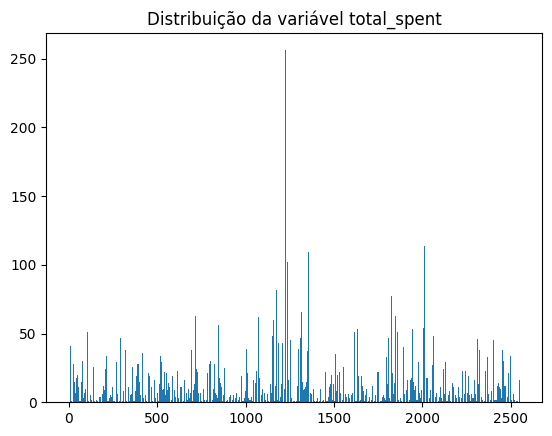

In [85]:
x=y.value_counts()
plt.bar(x.index,x)
plt.title('Distribuição da variável total_spent')
plt.show()

In [90]:
#criando um objeto StandardScaler object e aplicando isso ao conjunto de treino
sc = StandardScaler()

#treinar o scaler e transformar a matriz para um conjunto de treino
X_train_st = sc.fit_transform(X_train)

linked = linkage(X_train_st, method='ward')

#### 5.1.1 Dendrograma


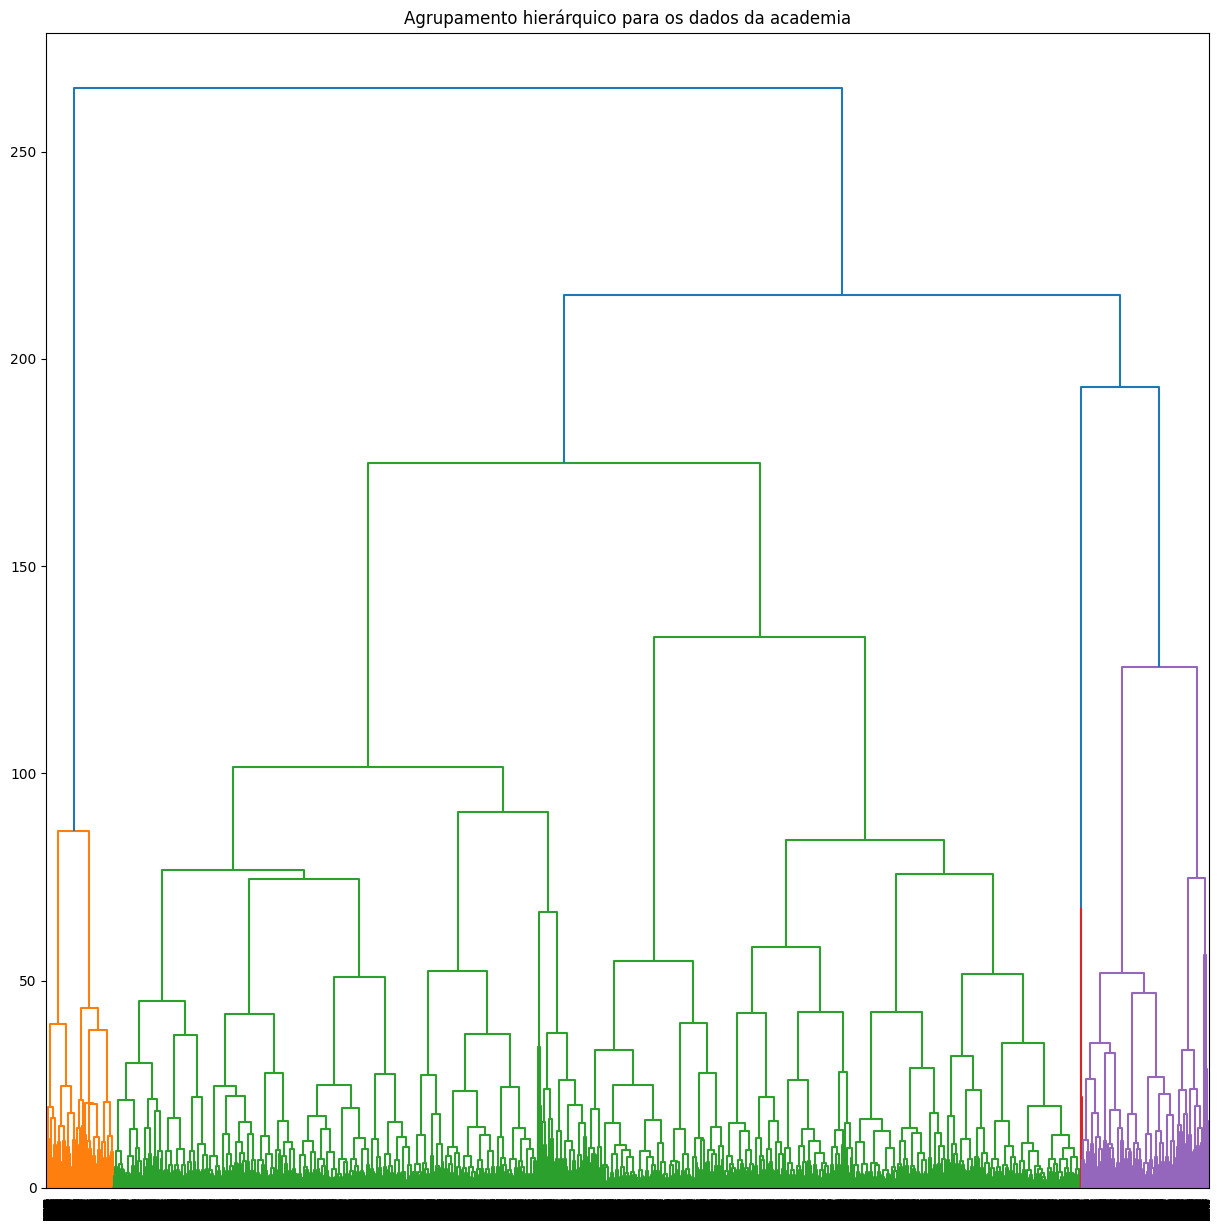

In [91]:
#plotando o dendrograma

plt.figure(figsize=[15,15])
dendrogram(linked, orientation='top')
plt.title('Agrupamento hierárquico para os dados da academia')
plt.show()

- Consigo realizar 5 agrupamentos.